# Digital Musicology (DH-401)
## Assignment 3: Similarity
Group 6
- Mickaël Achkar
- Yichen Wang
- Yinghui Jiang

In [1]:
import ms3
import pandas as pd
import numpy as np
import math
import fractions
import matplotlib.pyplot as plt
from scipy.fftpack import dct, idct
from scipy import signal, interpolate
from itertools import combinations
from numpy.fft import fft, ifft, fft2, ifft2, fftshift
from scipy.signal import correlate
pd.set_option('display.max_rows', 500)

## 0. Dataset preparation

In [2]:
%%time

# Suppress SettingWithCopy warnings
pd.options.mode.chained_assignment = None

# Import CSV
chorales_dataset = pd.read_csv('DM 2022 - Assignment 3 [Dataset].csv', converters = {'mn_onset': fractions.Fraction, 'act_dur': fractions.Fraction, 'duration': fractions.Fraction, 'nominal_duration': fractions.Fraction, 'scalar': fractions.Fraction}, index_col = 0, low_memory = False)

# Remove Chorale043 because it is corrupted (it does not open in MuseScore, it does not include a closing fermata, and it has only 1 staff)
chorales_dataset = chorales_dataset[chorales_dataset['piece'] != 'BachChorales/Chorale043']

# Remove "BachChorales/" from the piece names for better readability
chorales_dataset['piece'] = chorales_dataset['piece'].str.replace('BachChorales/', '')

## Add global onset column for easy time series manipulations (in units of whole notes)
# Sort accordingly
chorales_dataset = chorales_dataset.sort_values(by=['piece', 'staff', 'mn', 'mn_onset'])
# Shift duration column by 1
chorales_dataset['_shift_dur'] = np.roll(chorales_dataset['duration'], 1)
# Get invalid first shifts that will be removed
chorales_dataset['_first_shift'] = chorales_dataset.groupby(['piece','staff'])['_shift_dur'].transform('first')
# Cumulate shifted durations
chorales_dataset['_cum_dur_uncleaned'] = chorales_dataset.groupby(['piece','staff'])['_shift_dur'].transform(pd.Series.cumsum)
# Subtract invalid first shifts
chorales_dataset['global_onset'] = (chorales_dataset['_cum_dur_uncleaned'] - chorales_dataset['_first_shift'])
# Remove temp coliumns
chorales_dataset = chorales_dataset.drop(columns = ['_shift_dur','_first_shift','_cum_dur_uncleaned'])

# Ignore gracenotes (there is only one)
chorales_dataset = chorales_dataset[chorales_dataset['gracenote'].isna()].drop(columns = ['gracenote'])

# Get unique piece/staff pairs
piece_staffs = chorales_dataset.groupby('piece')['staff'].unique().to_dict()

# Consider only until the fermata in or after the 4th bar
fermata_data = []
for piece in piece_staffs.keys():
    for staff in piece_staffs[piece]:
        for idx, row in chorales_dataset[(chorales_dataset['piece'] == piece) & (chorales_dataset['staff'] == staff)].iterrows():
            fermata_data.append(row)
            if row['fermata'] and row['mn'] >= 4:
                break
fermata_df = pd.DataFrame(fermata_data)

# Sort by onset and staff for consistent alignment
fermata_df = fermata_df.sort_values(by=['piece', 'mn', 'mn_onset', 'staff']).reset_index(drop=True)

# Create dictionaries of last onsets, total piece durations, and smallest notes in each piece for future use
last_piece_onsets = fermata_df.groupby('piece')['global_onset'].max().apply(float).to_dict()
total_piece_durations = fermata_df.groupby(['piece','staff'])['duration'].sum().groupby('piece').max().apply(float).to_dict()
minimum_note_durations = fermata_df.groupby('piece')['duration'].min().apply(float).to_dict()

CPU times: user 15.3 s, sys: 317 ms, total: 15.7 s
Wall time: 16 s


In [3]:
# Display dataframe for random piece up to desired fermata
random_piece = fermata_df['piece'].sample(n=1).item()
random_piece_df = fermata_df[(fermata_df['piece'] == random_piece)]
random_piece_df

,piece,mn,mn_onset,timesig,act_dur,staff,voice,duration,nominal_duration,scalar,tied,tpc,midi,fermata,global_onset
5144,Chorale072,0,3/4,4/4,1/4,1,1,1/8,1/8,1,NaN,1,67,False,0
5145,Chorale072,0,3/4,4/4,1/4,2,1,1/4,1/4,1,NaN,2,62,False,0
5146,Chorale072,0,3/4,4/4,1/4,3,1,1/8,1/8,1,NaN,-2,58,False,0
5147,Chorale072,0,3/4,4/4,1/4,4,1,1/4,1/4,1,NaN,1,43,False,0
5148,Chorale072,0,7/8,4/4,1/4,1,1,1/8,1/8,1,NaN,3,69,False,1/8
5149,Chorale072,0,7/8,4/4,1/4,3,1,1/8,1/8,1,NaN,0,60,False,1/8
5150,Chorale072,1,0,4/4,1,1,1,1/4,1/4,1,NaN,-2,70,False,1/4
5151,Chorale072,1,0,4/4,1,2,1,1/8,1/8,1,NaN,1,67,False,1/4
5152,Chorale072,1,0,4/4,1,3,1,1/4,1/4,1,NaN,2,62,False,1/4
5153,Chorale072,1,0,4/4,1,4,1,1/4,1/4,1,NaN,1,55,False,1/4


## I. Similarity parameters
### a. Rhythm

In [4]:
%%time

# Sum durations of notes in each sampling bin
summed_durations_dict = {}
# Loop
for piece in piece_staffs.keys():
    piece_df = fermata_df[fermata_df['piece'] == piece]

    last_onset = last_piece_onsets[piece]
    sampling_period = minimum_note_durations[piece]

    bins = np.arange(0, (last_onset+sampling_period+1e-10), sampling_period)
    binned_onsets = pd.cut(piece_df['global_onset'], bins, right = True)
    summed_durations_dict[piece] = piece_df.groupby(binned_onsets)['duration'].sum().apply(float)

CPU times: user 3.73 s, sys: 22.7 ms, total: 3.75 s
Wall time: 3.8 s


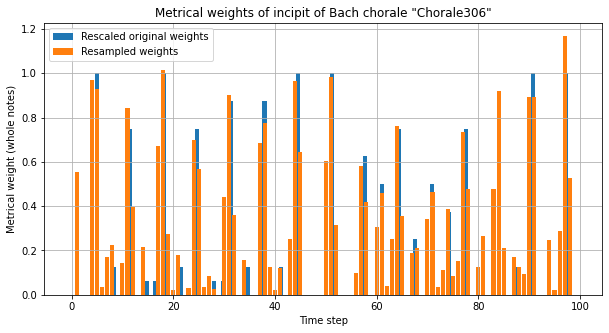

In [28]:
random_piece = fermata_df['piece'].sample(n=1).item()

last_onset = last_piece_onsets[random_piece]
sampling_period = minimum_note_durations[random_piece]
time_steps = np.arange(0, (last_onset+1e-10), sampling_period)
summed_durations = summed_durations_dict[random_piece].values

N = 100
time_steps_resampled = np.arange(0, N, 1)
# Sample 100 equally spaced weights (set negative weights to 0)
summed_durations_resampled = [max(res, 0) for res in signal.resample(summed_durations, num=N)]

plt.figure(figsize=(10, 5))
plt.bar(time_steps*(N-1)/last_piece_onsets[random_piece], summed_durations)
plt.bar(time_steps_resampled, summed_durations_resampled)
plt.xlabel('Time step')
plt.ylabel('Metrical weight (whole notes)')
plt.title(f'Metrical weights of incipit of Bach chorale "{random_piece}"')
plt.legend(['Rescaled original weights', 'Resampled weights'])
plt.grid()
plt.show()

In [6]:
# # Compute fft for each phrase for rhythm represenation

# fft_freq = {}
# for piece in piece_staffs:
#     summed_durations = summed_durations_dict[piece].values
#     # Sample 100 equally spaced pitches
#     N = 100
#     time_steps_resampled = np.arange(0, N, 1)
#     summed_durations_resampled = [max(res, 0) for res in signal.resample(summed_durations, num=N)]
    
#     # Compute Fast fourier transform of signal
#     phrase_fft = fft(summed_durations_resampled, norm='ortho', n=N)
#     phrase_fft[0] = 0
#     fft_freq[piece] = phrase_fft

In [7]:
# # Get unique combinations of pieces (total of 66430 unique combinations)
# piece_pairs = combinations(piece_staffs.keys(), 2)
# rhythm_dict = {}

# # Get Euclidian distance (L2 norm) between two pairs
# for pair in piece_pairs:
#     L2_norm = np.linalg.norm(correlate(fft_freq[pair[0]],fft_freq[pair[1]],'full'), 2)
#     rhythm_dict[frozenset(pair)] = L2_norm

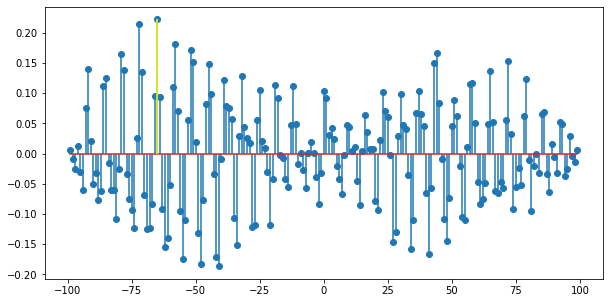

In [309]:
random_piece_1 = fermata_df['piece'].sample(n=1).item()
last_onset = last_piece_onsets[random_piece_1]
sampling_period = minimum_note_durations[random_piece_1]
time_steps = np.arange(0, (last_onset+1e-10), sampling_period)
summed_durations = summed_durations_dict[random_piece_1].values

N = 100
time_steps_resampled = np.arange(0, N, 1)
# Sample 100 equally spaced weights (set negative weights to 0)
summed_durations_resampled_1 = [max(res, 0) for res in signal.resample(summed_durations, num=N)]

random_piece_2 = fermata_df['piece'].sample(n=1).item()
last_onset = last_piece_onsets[random_piece_2]
sampling_period = minimum_note_durations[random_piece_2]
time_steps = np.arange(0, (last_onset+1e-10), sampling_period)
summed_durations = summed_durations_dict[random_piece_2].values

N = 100
time_steps_resampled = np.arange(0, N, 1)
# Sample 100 equally spaced weights (set negative weights to 0)
summed_durations_resampled_2 = [max(res, 0) for res in signal.resample(summed_durations, num=N)]

a=(summed_durations_resampled_1 - np.mean(summed_durations_resampled_1))/np.std(summed_durations_resampled_1)
b=(summed_durations_resampled_2 - np.mean(summed_durations_resampled_2))/np.std(summed_durations_resampled_2)

corr = correlate(a, b, 'full')/100

plt.figure(figsize=(10, 5))
plt.stem(range(-N+1,N), corr)
plt.vlines(x=np.argmax(corr)-(N-1), ymin=0, ymax=max(corr), color='yellow')

In [230]:
# Compute 

normalized_summeds__durations = {}
for piece in piece_staffs:
    summed_durations = summed_durations_dict[piece].values
    # Sample 100 equally spaced pitches
    N = 100
    time_steps_resampled = np.arange(0, N, 1)
    summed_durations_resampled = [max(res, 0) for res in signal.resample(summed_durations, num=N)]    
    normalized_summed_durations[piece] = (summed_durations_resampled - np.mean(summed_durations_resampled))/np.std(summed_durations_resampled)

In [354]:
# Get unique combinations of pieces (total of 66430 unique combinations)
piece_pairs = combinations(piece_staffs.keys(), 2)
rhythm_dict = {}

# Get Euclidian distance (L2 norm) between two pairs
for pair in piece_pairs:
    sig_pair_a = normalized_summed_durations[pair[0]]
    sig_pair_b = normalized_summed_durations[pair[1]]

    cross_corr = correlate(sig_pair_a, sig_pair_b, 'full')/min(len(sig_pair_a), len(sig_pair_b))
    cross_corr = np.array([max(corr,0) for corr in cross_corr])
    positives = cross_corr[cross_corr > 0]
    rhythm_dict[frozenset(pair)] = np.mean(positives)
    # rhythm_dict[frozenset(pair)] = max(cross_corr)    
    # rhythm_dict[frozenset(pair)] = sum(positives)

# rhythm_dict

In [355]:
# Get best and worst rhythm similarities
sorted_rhythm_scores= dict(sorted(rhythm_dict.items(), key=lambda item: item[1], reverse = True)) 

N = 40
print(f'\nBest {N} rhythm similarities:\n')
for i in range(N):
    print(f'{i+1}: {set(list(sorted_rhythm_scores.items())[i][0])}: {round(list(sorted_rhythm_scores.items())[i][1], 5)}')

N = 10
print(f'\nWorst {N} rhythm similarities:\n')
for i in range(-1,-N-1,-1):
    print(f'{-i}: {set(list(sorted_rhythm_scores.items())[i][0])}: {round(list(sorted_rhythm_scores.items())[i][1], 5)}')
    print(fermata_df[fermata_df['piece'] == list(list(sorted_rhythm_scores.items())[i][0])[0]]['timesig'].sample(n=1).item())
    print(fermata_df[fermata_df['piece'] == list(list(sorted_rhythm_scores.items())[i][0])[1]]['timesig'].sample(n=1).item())


Best 40 rhythm similarities:

1: {'Chorale292', 'Chorale066'}: 0.30294
2: {'Chorale278', 'Chorale066'}: 0.29997
3: {'Chorale047', 'Chorale370'}: 0.29837
4: {'Chorale314', 'Chorale066'}: 0.29821
5: {'Chorale047', 'Chorale066'}: 0.29727
6: {'Chorale119', 'Chorale066'}: 0.29695
7: {'Chorale292', 'Chorale044'}: 0.29657
8: {'Chorale370', 'Chorale292'}: 0.29502
9: {'Chorale278', 'Chorale370'}: 0.29499
10: {'Chorale047', 'Chorale044'}: 0.29442
11: {'Chorale119', 'Chorale044'}: 0.29409
12: {'Chorale314', 'Chorale278'}: 0.29401
13: {'Chorale278', 'Chorale044'}: 0.29397
14: {'Chorale250', 'Chorale278'}: 0.29255
15: {'Chorale066', 'Chorale044'}: 0.29216
16: {'Chorale066', 'Chorale026'}: 0.29201
17: {'Chorale066', 'Chorale322'}: 0.29187
18: {'Chorale047', 'Chorale260'}: 0.29156
19: {'Chorale119', 'Chorale026'}: 0.29125
20: {'Chorale314', 'Chorale119'}: 0.29119
21: {'Chorale066', 'Chorale277'}: 0.29097
22: {'Chorale047', 'Chorale278'}: 0.2909
23: {'Chorale047', 'Chorale156'}: 0.29089
24: {'Chorale

### b. Melodic contour

In [9]:
%%time

# Create dictionary of frontfilled pitches for each piece and staff in each sampling bin
piece_staff_pitches_dict = {}
# Loop
for piece in piece_staffs.keys():
    for staff in piece_staffs[piece]:
        piece_staff_df = fermata_df[(fermata_df['piece'] == piece) & (fermata_df['staff'] == staff)]

        total_duration = total_piece_durations[piece]
        sampling_period = minimum_note_durations[piece]
        
        # Create equally spaced and normalized bins sampled by minimum note resolution
        bins = np.arange(0, 1+1e-10, sampling_period/total_duration)
        binned_onsets = pd.cut(piece_staff_df['global_onset'], bins, right = False)
        # Front fill midi values as long as the onset lasts  
        piece_staff_pitches_dict[(piece,staff)] = piece_staff_df.groupby(binned_onsets)['midi'].first().ffill()

# Get mean pitches for each piece
# This is done by calculating the sum of pitches across staves and dividing by the number of staves
mean_pitches_dict = {}
for piece in piece_staffs.keys():
    cumsum = 0
    for staff in piece_staffs[piece]:
        cumsum += piece_staff_pitches_dict[(piece,staff)]
    num_staves = max(piece_staffs[piece])
    mean_pitches_dict[piece] = cumsum / num_staves

# Manipulate data to get time series vs. pitches for each piece
melodic_contours = {}
for piece in piece_staffs.keys():
    time_steps = np.arange(0, 1+1e-10, minimum_note_durations[piece]/total_piece_durations[piece])
    pitches = mean_pitches_dict[piece].values
    # Front fill up to final normalized duration
    pitches = np.append(pitches, pitches[-1])
    melodic_contours[piece] = (time_steps,pitches)

CPU times: user 12.4 s, sys: 76.4 ms, total: 12.4 s
Wall time: 12.5 s


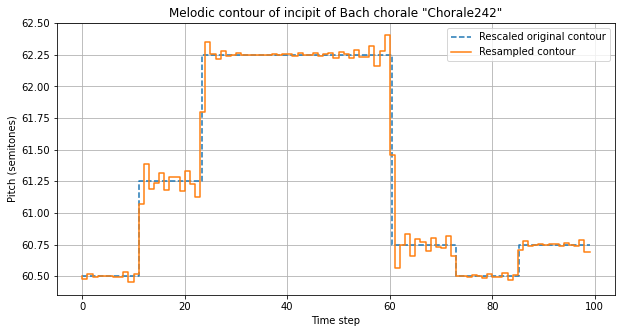

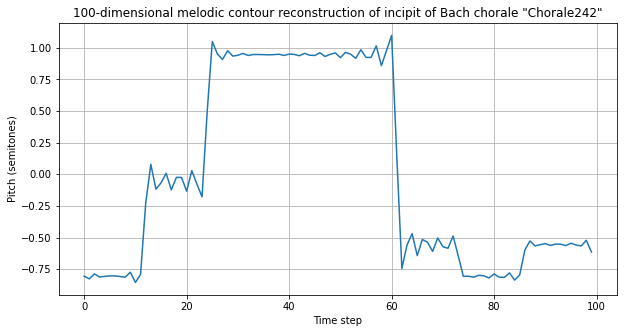

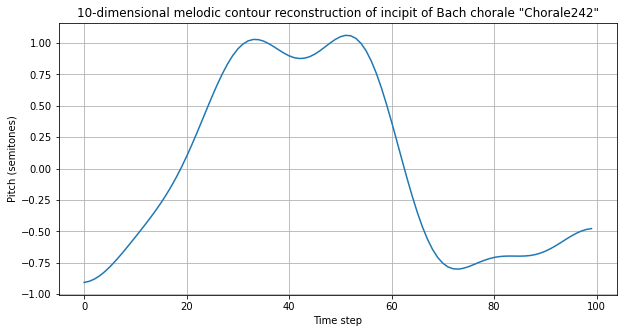

In [10]:
# Plot melodic contour of a random phrase
random_piece = fermata_df['piece'].sample(n=1).item()

time_steps = melodic_contours[random_piece][0]
pitches = melodic_contours[random_piece][1]

# Sample 100 equally spaced pitches
N = 100
time_steps_resampled = np.arange(0, N, 1)
pitches_resampled = signal.resample(pitches, num=N)

plt.figure(figsize=(10, 5))
plt.step(time_steps*(N-1), pitches, '--', time_steps_resampled, pitches_resampled, '-')
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.title(f'Melodic contour of incipit of Bach chorale "{random_piece}"')
plt.legend(['Rescaled original contour', 'Resampled contour'])
plt.grid()
plt.show()

# Compute Discrete Cosine transform of signal
phrase_dct = dct(pitches_resampled, norm='ortho', n=N)

# Discard first coefficient c0 to make contour transposition invariant
phrase_dct[0] = 0

# Reconstruct the phrase using all dimensions dimensions
D = 100
reconstructed_phrase = idct(phrase_dct[0:D], norm='ortho', n=N)
plt.figure(figsize=(10, 5))
plt.title(f'{D}-dimensional melodic contour reconstruction of incipit of Bach chorale "{random_piece}"')
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.grid()
plt.plot(reconstructed_phrase)
plt.show()

# Reconstruct the phrase using only D dimensions
D = 10
reconstructed_phrase = idct(phrase_dct[0:D], norm='ortho', n=N)
plt.figure(figsize=(10, 5))
plt.title(f'{D}-dimensional melodic contour reconstruction of incipit of Bach chorale "{random_piece}"')
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.grid()
plt.plot(reconstructed_phrase)
plt.show()

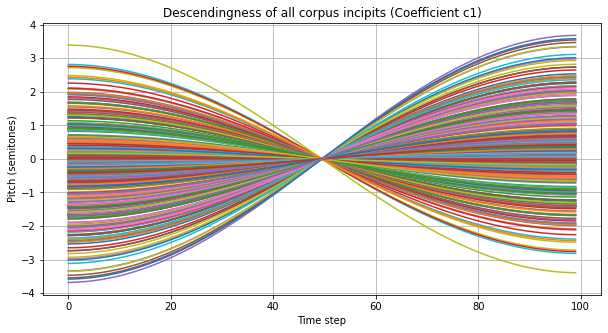

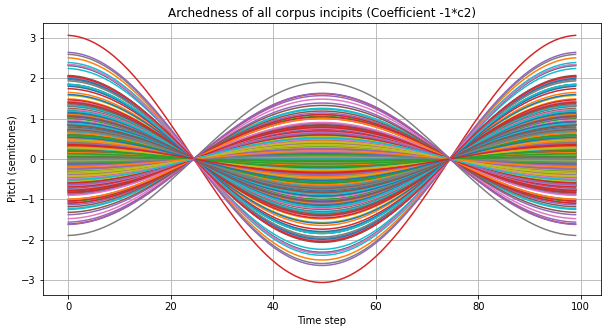

In [11]:
# For visualization, plot the descendingness contours of all phrases
plt.figure(figsize=(10, 5))
plt.title("Descendingness of all corpus incipits (Coefficient c1)")
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.grid()
for piece in piece_staffs.keys():
    time_steps = melodic_contours[piece][0]
    pitches = melodic_contours[piece][1]
    
    # Sample 100 equally spaced pitches
    N = 100
    time_steps_resampled = np.arange(0, N, 1)
    pitches_resampled = signal.resample(pitches, num=N)

    # Compute Discrete Cosine transform of signal
    desc_dct = dct(pitches_resampled, norm='ortho', n=N)

    # Discard first coefficient c0 to make contour transposition invariant
    desc_dct[0] = 0

    # Plot "descendingness" c1 coefficients reconstructions for all phrases
    D = 2
    phrase_descendingness = idct(desc_dct[0:D], norm='ortho', n=N)
    plt.plot(phrase_descendingness)

# For visualization, plot the archedness contours of all phrases
plt.figure(figsize=(10, 5))
plt.title("Archedness of all corpus incipits (Coefficient -1*c2)")
plt.xlabel('Time step')
plt.ylabel('Pitch (semitones)')
plt.grid()
for piece in piece_staffs.keys():
    time_steps = melodic_contours[piece][0]
    pitches = melodic_contours[piece][1]

    # Sample 100 equally spaced pitches
    N = 100
    time_steps_resampled = np.arange(0, N, 1)
    time_steps_resampled = np.arange(0, 100, 1)
    pitches_resampled = signal.resample(pitches, num=100)

    # Compute Discrete Cosine transform of signal
    arch_dct = dct(pitches_resampled, norm='ortho', n=100)

    # Discard first coefficient c0 to make contour transposition invariant
    arch_dct[0] = 0    
    # Discard second coefficient c1 to only represent c2
    arch_dct[1] = 0

    # Plot "archedness" -1*c2 coefficients reconstructions for all phrases
    D = 3
    reconstructed_phrase_archedness = idct(-1*arch_dct[0:D], norm='ortho', n=100)
    plt.plot(reconstructed_phrase_archedness)

In [12]:
# Compute first D cosine transform coefficients for each phrase for a low-dimensional melody represenation

cosine_coeffs = {}
for piece in piece_staffs.keys():
    pitches = melodic_contours[piece][1]

    # Sample 100 equally spaced pitches
    N = 100
    pitches_resampled = signal.resample(pitches, num=N)

    # Compute Discrete Cosine transform of signal
    phrase_dct = dct(pitches_resampled, norm='ortho', n=N)

    # Discard first coefficient c0 to make contour transposition invariant
    phrase_dct[0] = 0

    # Get only D coefficients for a low-dimensional representation
    D = 10
    cosine_coeffs[piece] = phrase_dct[0:D]

# Get unique combinations of pieces (total of 66430 unique combinations)
piece_pairs = combinations(piece_staffs.keys(), 2)
melody_dict = {}

# Get Euclidian distance (L2 norm) between two pairs
for pair in piece_pairs:
    L2_norm = np.linalg.norm(cosine_coeffs[pair[0]] - cosine_coeffs[pair[1]], 2)
    melody_dict[frozenset(pair)] = L2_norm

In [38]:
# Get best and worst melodic contour similarities
sorted_melody_scores= dict(sorted(melody_dict.items(), key=lambda item: item[1])) 

N = 50
print(f'\nBest {N} melodic contour similarities:\n')
for i in range(N):
    print(f'{i+1}: {set(list(sorted_melody_scores.items())[i][0])}: {round(list(sorted_melody_scores.items())[i][1], 5)}')

N = 10
print(f'\nWorst {N} melodic contour similarities:\n')
for i in range(-1,-N-1,-1):
    print(f'{-i}: {set(list(sorted_melody_scores.items())[i][0])}: {round(list(sorted_melody_scores.items())[i][1], 5)}')



Best 50 melodic contour similarities:

1: {'Chorale009', 'Chorale361'}: 0.0
2: {'Chorale088', 'Chorale023'}: 0.0
3: {'Chorale097', 'Chorale036'}: 0.0
4: {'Chorale053', 'Chorale178'}: 0.0
5: {'Chorale112', 'Chorale062'}: 0.0
6: {'Chorale098', 'Chorale080'}: 0.0
7: {'Chorale195', 'Chorale086'}: 0.0
8: {'Chorale305', 'Chorale086'}: 0.0
9: {'Chorale091', 'Chorale259'}: 0.0
10: {'Chorale257', 'Chorale093'}: 0.0
11: {'Chorale099', 'Chorale114'}: 0.0
12: {'Chorale120', 'Chorale115'}: 0.0
13: {'Chorale349', 'Chorale115'}: 0.0
14: {'Chorale120', 'Chorale349'}: 0.0
15: {'Chorale318', 'Chorale144'}: 0.0
16: {'Chorale156', 'Chorale308'}: 0.0
17: {'Chorale195', 'Chorale305'}: 0.0
18: {'Chorale307', 'Chorale198'}: 0.0
19: {'Chorale199', 'Chorale302'}: 0.0
20: {'Chorale306', 'Chorale201'}: 0.0
21: {'Chorale235', 'Chorale319'}: 0.0
22: {'Chorale236', 'Chorale295'}: 0.0
23: {'Chorale248', 'Chorale354'}: 0.0
24: {'Chorale254', 'Chorale282'}: 0.0
25: {'Chorale313', 'Chorale353'}: 0.0
26: {'Chorale130', 

## c. Harmony

In [24]:
%%time 

# Group pitches by global_onset for each phrase (preserves unisons)
chords_df = fermata_df.groupby(['piece','global_onset'])['midi'].apply(list).reset_index()

# Get only chords (2 or more pitches at the same onset)
mask = [i for i in range(len(chords_df)) if len(chords_df['midi'][i]) != 1]
# Apply mask to get chords and rename column
chords_df = chords_df.iloc[mask].rename(columns={'midi':'chord'})
chords_df

CPU times: user 488 ms, sys: 23.4 ms, total: 512 ms
Wall time: 634 ms


,piece,global_onset,chord
0,Chorale001,0,"[67, 62, 59, 43]"
1,Chorale001,1/4,"[67, 62, 59, 55]"
2,Chorale001,1/2,"[64, 60, 52]"
4,Chorale001,3/4,"[74, 62, 57, 54]"
5,Chorale001,1,"[71, 62, 55, 55]"
...,...,...,...
9219,Chorale371,3,"[67, 64, 59, 55]"
9221,Chorale371,13/4,"[66, 64, 59, 59]"
9222,Chorale371,27/8,"[64, 63]"
9224,Chorale371,7/2,"[66, 63, 47]"


In [15]:
# Create a map between intervals in semitones and interval qualities, and additional consonance/dissonance classes
interval_labels = ['P1/P8', 'm2/M7', 'M2/m7', 'm3/M6', 'M3/m6', 'P4/P5', '4+/5°', 
                   'Consonances (P1/P8, m3/M6, M3/m6, P4/P5)', 'Dissonances (m2/M7, M2/m7, 4+/5°)']
interval_map = [{0}, {1,11}, {2,10}, {3,9}, {4,8}, {5,7}, {6}, {0,3,9,4,8,5,7}, {1,11,2,10,6}]

# Create interval qualities frequency vectors for each phrase
harmony_vectors = {}
for piece in piece_staffs.keys():
    interval_classes = np.zeros(9)
    for chord in chords_df[(chords_df['piece'] == piece)]['chord']:
        # Get all unique interval combinations in a chord
        for comb in combinations(chord, 2):
            for key,interval in enumerate(interval_map):
                # Convert interval to chromatic pitch-class ordered in semitones
                cpc_comb = (comb[0]-comb[1])%12
                # Map the interval size to its quality
                if cpc_comb in interval:
                    interval_classes[key] += 1
    # Normalize by total interval counts per piece
    harmony_vectors[piece] = interval_classes / sum(interval_classes[7:9])

In [23]:
# Get interval class vector of a random phrase
random_piece = fermata_df['piece'].sample(n=1).item()

print(f'Interval class frequencies of incipit of chorale {random_piece}:\n')
for label, freq in zip(interval_labels, harmony_vectors[random_piece]):
    print(f'{label}: {round(freq*100, 2)}%')

Interval class frequencies of incipit of chorale Chorale149:

P1/P8: 16.48%
m2/M7: 0.0%
M2/m7: 3.3%
m3/M6: 25.27%
M3/m6: 23.08%
P4/P5: 29.67%
4+/5°: 2.2%
Consonances (P1/P8, m3/M6, M3/m6, P4/P5): 94.51%
Dissonances (m2/M7, M2/m7, 4+/5°): 5.49%


In [17]:
# Get unique combinations of pieces (total of 66430 unique combinations)
piece_pairs = combinations(piece_staffs.keys(), 2)
harmony_dict = {}

# Get Euclidian distance (L2 norm) between two pairs
for pair in piece_pairs:
    L2_norm = np.linalg.norm(harmony_vectors[pair[0]] - harmony_vectors[pair[1]], 2)
    harmony_dict[frozenset(pair)] = L2_norm

In [37]:
# Get best and worst harmonic content similarities
sorted_harmony_scores= dict(sorted(harmony_dict.items(), key=lambda item: item[1])) 

N = 40
print(f'\nBest {N} harmonic content similarities:\n')
for i in range(N):
    print(f'{i+1}: {set(list(sorted_harmony_scores.items())[i][0])}: {round(list(sorted_harmony_scores.items())[i][1], 5)}')

N = 10
print(f'\nWorst {N} harmonic content similarities:\n')
for i in range(-1,-N-1,-1):
    print(f'{-i}: {set(list(sorted_harmony_scores.items())[i][0])}: {round(list(sorted_harmony_scores.items())[i][1], 5)}')


Best 40 harmonic content similarities:

1: {'Chorale309', 'Chorale005'}: 0.0
2: {'Chorale009', 'Chorale361'}: 0.0
3: {'Chorale053', 'Chorale178'}: 0.0
4: {'Chorale064', 'Chorale256'}: 0.0
5: {'Chorale079', 'Chorale296'}: 0.0
6: {'Chorale195', 'Chorale086'}: 0.0
7: {'Chorale305', 'Chorale086'}: 0.0
8: {'Chorale091', 'Chorale259'}: 0.0
9: {'Chorale257', 'Chorale093'}: 0.0
10: {'Chorale120', 'Chorale349'}: 0.0
11: {'Chorale130', 'Chorale358'}: 0.0
12: {'Chorale318', 'Chorale144'}: 0.0
13: {'Chorale156', 'Chorale308'}: 0.0
14: {'Chorale195', 'Chorale305'}: 0.0
15: {'Chorale307', 'Chorale198'}: 0.0
16: {'Chorale199', 'Chorale302'}: 0.0
17: {'Chorale306', 'Chorale201'}: 0.0
18: {'Chorale235', 'Chorale319'}: 0.0
19: {'Chorale236', 'Chorale295'}: 0.0
20: {'Chorale248', 'Chorale354'}: 0.0
21: {'Chorale254', 'Chorale282'}: 0.0
22: {'Chorale304', 'Chorale281'}: 0.0
23: {'Chorale313', 'Chorale353'}: 0.0
24: {'Chorale177', 'Chorale148'}: 0.0081
25: {'Chorale280', 'Chorale239'}: 0.00934
26: {'Chora